# E-tivity 2 Weeks 3-4

* David Sheridan

* 24300446

## Outline

This e-tivity is split into two parts. The first part <a href="#part1">**Stock Predicition**</a> is a group activity where you are tasked with predicting the stock market.

The second <a href="#part2">**Sentiment Analysis**</a> is an individual task, the problem is to predict if a film review is positive or negative.

### Guidelines

The e-tivity is split into five tasks. The first four are "group" excersises, in that you post the solutions to Tasks 1-4 to the Group Locker. This will allow the members of your group to send you feedback (via the forums) so you can improve your submission. The final task is an individual task and together with the other tasks, should be uploaded to Brightspace.

Marks will be deducted if task 5 is uploaded in contravention of instructions. Also if the the final submission is not a single notebook with tasks 1-5 and with correct identification or filename.


Grading guidelines: the rubrics for the e-tivity are here https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4446&originTool=quicklinks





<a id='part1'></a>
## Stock Prediction

### Context

There is a small dataset of real stock prices for each working day from the end of 2015 to the end of 2019. There are four variables (with a time stamp), stock price, oil price, gold price and Euro to Dollar exchange. You need to predict the Stock price a day ahead from only the past values of each of the 4 variables. 


### Tasks 1-4 (complete by Sunday Week 4)

Create additional cells to complete the tasks below. These form the group exercises and you can upload your code for Tasks 1-4 to the group locker. 

**Task 1: data preprocessing**

Explain any preprocessing steps you take including but limited to reformatting and also how you have selected the training and test sets. The test set should be 20% of the whole.


In [27]:
#Importing Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [37]:
#Loading Data
#Read CSV file, parse_dates converts Date column into datetime format, index_col sets Date as index for time-series structure
df = pd.read_csv("stock.csv", parse_dates=["Date"], index_col="Date")

# Display first rows to confirm loading
print(df.head())

                  Stock        Oil  EuroToDollar    Gold
Date                                                    
2015-11-23  2089.409912  41.490002        0.9432  1124.7
2015-11-24  2084.419922  42.040001        0.9388  1131.6
2015-11-25  2089.300049  42.689999        0.9420  1128.4
2015-11-27  2088.820068  43.250000        0.9438  1114.5
2015-11-30  2090.949951  41.770000        0.9468  1123.9


In [39]:
#Ensuring chronological order
df = df.sort_index()

In [41]:
#Inspecting Data Structure
print("\nDataset shape:", df.shape)
print("\nMissing values:\n", df.isna().sum())
print("\nData types:\n", df.dtypes)


Dataset shape: (1033, 4)

Missing values:
 Stock            0
Oil             10
EuroToDollar    12
Gold             0
dtype: int64

Data types:
 Stock           float64
Oil             float64
EuroToDollar    float64
Gold            float64
dtype: object


In [43]:
#Scaling features
#Creating scaler object
scaler = MinMaxScaler()

#Fitting scaler and transform data
scaled_values = scaler.fit_transform(df)

#Converting back to DataFrame for readability
df_scaled = pd.DataFrame(scaled_values,
                         columns=df.columns,
                         index=df.index)

In [45]:
#Creating supervised learning target
#Shifting Stock column up by 1 day to create prediction target (allows model to predict tomorrow's stock value)
df_scaled["Target"] = df_scaled["Stock"].shift(-1)

#Removing final row (no future value available)
df_scaled = df_scaled.dropna()

In [47]:
#Train/Test split (80/20)
#Determine split index
split_index = int(len(df_scaled) * 0.8)

#First 80% used for training
train = df_scaled.iloc[:split_index]

#Last 20% used for testing
test = df_scaled.iloc[split_index:]

print("\nTraining samples:", len(train))
print("Testing samples:", len(test))

#Separate features and target
X_train = train.drop("Target", axis=1)
y_train = train["Target"]

X_test = test.drop("Target", axis=1)
y_test = test["Target"]

print("\nFeature shape:", X_train.shape)
print("Target shape:", y_train.shape)


Training samples: 810
Testing samples: 203

Feature shape: (810, 4)
Target shape: (810,)


**Task 2: data cleaning**

There are a number of missing values in the data. Clean the data so that it is suitable for use with the NN. Bare in mind that you want to retain the time coherency of the data as much as possible. Explain the steps you have taken.


In [51]:
#Check missing values before cleaning
print("Missing values before cleaning:\n")
print(df.isna().sum())

Missing values before cleaning:

Stock            0
Oil             10
EuroToDollar    12
Gold             0
dtype: int64


In [53]:
#Handle missing values
#Forward fill replaces missing values with the previous day's value (preserves time order and avoids using future information)
df_clean = df.ffill()

In [55]:
#Verifying cleaning
print("\nMissing values after forward fill:\n")
print(df_clean.isna().sum())

#Confirming no missing values remain
print("\nAny missing values remaining?", df_clean.isna().values.any())


Missing values after forward fill:

Stock           0
Oil             0
EuroToDollar    0
Gold            0
dtype: int64

Any missing values remaining? False


In [57]:
#Inspecting filled values
#Show rows where missing values originally occurred (helps confirm forward fill worked correctly)
missing_rows = df[df.isna().any(axis=1)]
print("\nRows that originally contained missing values:\n")
print(missing_rows.head())


Rows that originally contained missing values:

                  Stock        Oil  EuroToDollar    Gold
Date                                                    
2016-01-18  1916.680054        NaN           NaN  1090.2
2016-02-15  1833.400024        NaN           NaN  1234.0
2017-01-20  2269.959961  51.450001           NaN  1289.2
2017-07-03  2431.389893        NaN        0.8797  1289.9
2017-10-09  2551.389893  49.250000           NaN  1362.0


**Task 3: model construction**

Construct a RNN network that will predict the future value of Stock, one day/time inteval in advance.

In [61]:
#Creating sequences for RNN input
import numpy as np

#Number of past days used to predict the next day
WINDOW = 10

#Converting time-series data into sequences using previous 'window' days to predict the next value
def create_sequences(X, y, window):
    X_seq, y_seq = [], []

    for i in range(window, len(X)):
        #collect previous 'window' days as input
        X_seq.append(X[i-window:i])

        #target is next day's stock price
        y_seq.append(y[i])

    return np.array(X_seq), np.array(y_seq)

#Creating training and testing sequences
X_train_seq, y_train_seq = create_sequences(X_train.values, y_train.values, WINDOW)
X_test_seq, y_test_seq = create_sequences(X_test.values, y_test.values, WINDOW)

print("Training sequence shape:", X_train_seq.shape)
print("Testing sequence shape:", X_test_seq.shape)

Training sequence shape: (800, 10, 4)
Testing sequence shape: (193, 10, 4)


In [65]:
#Building RNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, Dense, Dropout

#Initialising model
model = Sequential()

#Defining input shape 
model.add(Input(shape=(WINDOW, X_train_seq.shape[2])))

#GRU for learning temporal patterns from sequences
model.add(GRU(32))

#Dropout to help reduce overfitting
model.add(Dropout(0.2))

#Output layer for predicting next-day stock price
model.add(Dense(1, activation='linear'))

#Compiling model for regression task
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

#Displaying model architecture
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 32)                  │           3,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,681 (14.38 KB)

 Trainable params: 3,681 (14.38 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
#Training the model
from tensorflow.keras.callbacks import EarlyStopping

#Stopping training if validation performance stops improving
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2, #using part of training set for validation
    epochs=300,
    batch_size=128,
    shuffle=False, #for time series
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0017 - mae: 0.0309 - val_loss: 0.0013 - val_mae: 0.0314
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0014 - mae: 0.0281 - val_loss: 0.0011 - val_mae: 0.0282
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0013 - mae: 0.0270 - val_loss: 8.6473e-04 - val_mae: 0.0221
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0013 - mae: 0.0275 - val_loss: 8.9222e-04 - val_mae: 0.0230
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0013 - mae: 0.0266 - val_loss: 0.0011 - val_mae: 0.0286
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0014 - mae: 0.0279 - val_loss: 9.3338e-04 - val_mae: 0.0242
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0013 - mae: 0.0261 - val_loss: 8.6450e-04 - val_mae: 0.0219
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0013 - mae: 0.0278 - val_loss: 9.1024e-04 - val_mae: 0.0236
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step -

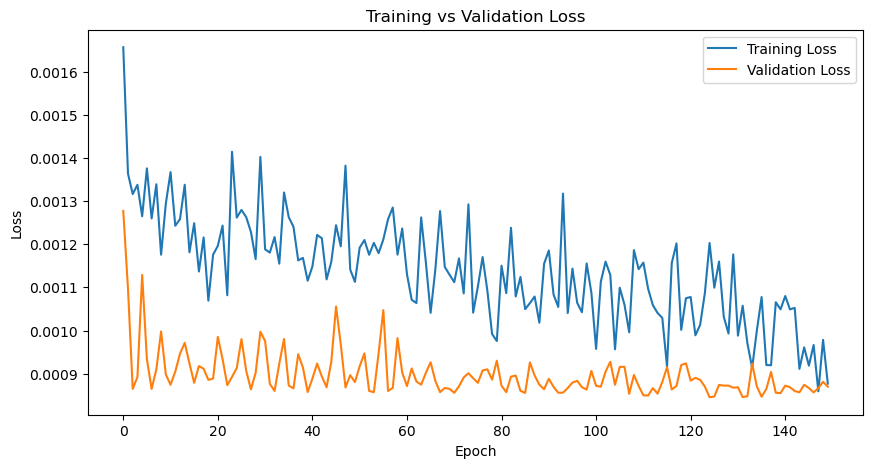

In [80]:
#Plotting training performance
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Task 4: test**

Evaluate the model on the test set and display any change in accuracy over time, if any. Test for common issues found in deep learning models.


In [82]:
#Generating predcitions
#Predicting on training sequences
train_predictions = model.predict(X_train_seq)

#Predicting on test sequences
test_predictions = model.predict(X_test_seq)

#Flattening arrays for easier comparison
train_predictions = train_predictions.flatten()
test_predictions = test_predictions.flatten()

#Actual values
train_actual = y_train_seq.flatten()
test_actual = y_test_seq.flatten()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [84]:
#Calculating error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

#Root Mean Squared Error (sensitive to large errors)
train_rmse = np.sqrt(mean_squared_error(train_actual, train_predictions))
test_rmse = np.sqrt(mean_squared_error(test_actual, test_predictions))

#Mean Absolute Error (average error)
train_mae = mean_absolute_error(train_actual, train_predictions)
test_mae = mean_absolute_error(test_actual, test_predictions)

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)

print("\nTraining MAE:", train_mae)
print("Testing MAE:", test_mae)

Training RMSE: 0.020232342715412428
Testing RMSE: 0.023703146546937785

Training MAE: 0.014245319143426633
Testing MAE: 0.019420176069398293


In [86]:
#Comparing with naive baseline (tomorrow = today)
#shifting actual values by 1 day
naive_pred = test_actual[:-1]
naive_actual = test_actual[1:]

naive_rmse = np.sqrt(mean_squared_error(naive_actual, naive_pred))

print("\nNaive baseline RMSE:", naive_rmse)


Naive baseline RMSE: 0.014421401030477263


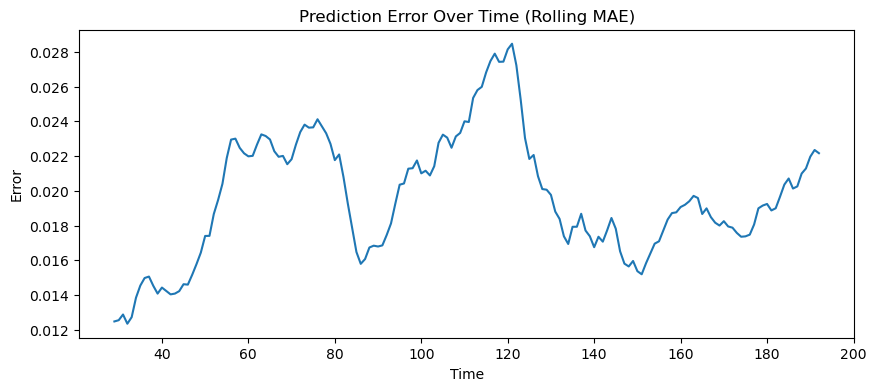

In [88]:
#Accuracy over time (rolling error)
import pandas as pd
import matplotlib.pyplot as plt

#Absolute error over time
errors = np.abs(test_actual - test_predictions)

#30-day rolling mean error
rolling_error = pd.Series(errors).rolling(window=30).mean()

plt.figure(figsize=(10,4))
plt.plot(rolling_error)
plt.title("Prediction Error Over Time (Rolling MAE)")
plt.xlabel("Time")
plt.ylabel("Error")
plt.show()

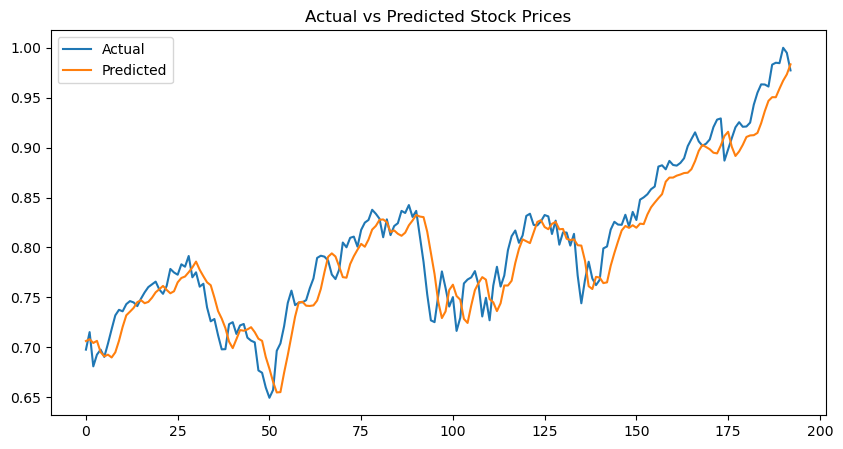

In [90]:
#Actual vs Predicted Plot
plt.figure(figsize=(10,5))

plt.plot(test_actual, label="Actual")
plt.plot(test_predictions, label="Predicted")

plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

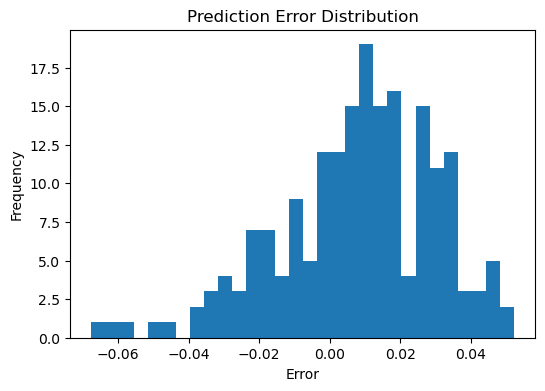

In [92]:
#Residual Distribution (bias check)
residuals = test_actual - test_predictions

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Prediction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

### Post (complete by Sunday Week 3)

Please upload your code for Tasks 1-4 to the group locker by Sunday if possible. The implementation does not need to be complete and you can continue to upload improved versions. The link is below. To organise things well; create a new subfolder in the locker for your work. You can upload multiple copies with different filenames to archive development stages. Post the link to the forum/topic. The purpose is to get feedback from others in the group, so if you have only a basic outline then you may get ideas about how to proceed and also examples from others in your group.

Post the location to the appropriate forum/topic.

No posts should reference Task 5.

### Respond (complete by Wednesday Week 4)

If you feel you can provide useful advise then respond to another member of the group through the appropriate forum. Responses should be respectful and offer some sort of advise. Try and avoid clogging the forums with support or thank you messages.

In reviewing others code you will discover different ways to tackle the same problem. It is acceptable to copy parts of others code. However whole scale copying from another notebook is not acceptable.

The group interaction forms part of the overall assessment. Grading guidelines for the forum posts: the rubrics for the e-tivity are here 
https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4446&originTool=quicklinks

<a id='part2'></a>
## Sentiment Analysis


This task is a individual task and should **not** to be uploaded to the Group Locker. No posts should be given via the forums. Marks will be deducted if the instructions are not followed (see rubrics). This part should be uploaded directly to Brightpsace.

### Context

You have a model that predicts the sentiment of a film review (positive or negative) from the IMDB. There are two hyperparameters that format the data from IMDB: the maximum review length and the dictionary size. Below is a RNN model that predicts sentiment values. 


### Task 5:  (completed by Sunday Week 4)

Keeping top_words, max_review_lenngth and the embedding_vector_length the same, change the model so that it uses attention only, i.e. there are no recurrent components. The only Keras layers (defined here https://www.tensorflow.org/api_docs/python/tf/keras/layers) that you allowed to use are:
- Input,
- Embedding, 
- Dense, 
- Any Attention (must be at leat one),
- TimeDistributed,
- Any Merging,
- Any Reshaping,
- Any Pooling,
- Dropout. 

You need not use any of the layers (except attention) but you can use some more than once. Can you do at least as good as the RNN example?

**NB** There are many examples of using attention for sentiment analysis but we looking to see if you can construct a sensible model. The model will be delibrately restricted, so do not waste too much time achieving spectacular accuracy. Remember the rules of thumb that we discussed in the Introduction to DL module.


In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np

top_words = 100
(Rev_train, Sc_train), (Rev_test, Sc_test) = imdb.load_data(num_words=top_words)

max_review_length = 500
X_train = sequence.pad_sequences(Rev_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(Rev_test, maxlen=max_review_length)
print(X_train.shape)

In [ ]:
embedding_vector_length = 16
model_imdb = Sequential()
model_imdb.add(Input(shape=(max_review_length,)))
model_imdb.add(Embedding(top_words, embedding_vector_length))
model_imdb.add(Dropout(0.2))
model_imdb.add(LSTM(10))
model_imdb.add(Dropout(0.2))
model_imdb.add(Dense(1, activation='sigmoid'))
model_imdb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_imdb.summary())
plot_model(model_imdb,show_shapes=True)


The history for the model above has been saved, as it takes a while to run. If you want to run it yourself then comment out the second line.


In [ ]:
nepoch = 150
#IMDB_history = model_imdb.fit(X_train,Sc_train,validation_data=(X_test,Sc_test),epochs=nepoch,batch_size=256)
IMDB_history=np.load('IMDBTrainhist.npy',allow_pickle='TRUE').item()

In [ ]:
plt.plot(range(nepoch),IMDB_history.history['loss'],c='r')
plt.plot(range(nepoch),IMDB_history.history['val_loss'],c='b')
plt.plot()

In [ ]:
plt.plot(range(nepoch),IMDB_history.history['accuracy'],c='r')
plt.plot(range(nepoch),IMDB_history.history['val_accuracy'],c='b')
plt.plot()

### Final Submission (complete by Sunday Week 4)

Submit Tasks 1-5 in a single notebook this before the deadline on Sunday.


In [25]:
## Add additional code cells to implememt the tasks stated above 

### Task 1:

For Task 1, I prepared the stock dataset so it could be used with a neural network.

I first loaded the data and set the Date column as the index to keep the time order intact, since this is time-series data. The dataset contains 1,033 daily records with four variables: Stock, Oil, Gold and EuroToDollar. I checked the dataset structure and confirmed that all variables are numeric. I also noticed a small number of missing values in the Oil and EuroToDollar columns, which I will address in the data cleaning step.

To make the data suitable for a neural network, I normalised the values using MinMax scaling so that all inputs are on a similar scale.

Because the goal is to predict the stock price one day ahead, I created a target variable by shifting the Stock column forward by one day. The final row was removed because it does not have a future value to predict.

Finally, I split the dataset chronologically to preserve the time sequence:

80% training data (810 samples)

20% testing data (203 samples)

This produced a training set with four input features and a target value representing the next day’s stock price, ready for modelling in the next task.

### Task 2:

For Task 2, I cleaned the dataset by addressing the missing values identified in the Oil and EuroToDollar columns. Before cleaning, there were 10 missing values in Oil and 12 in EuroToDollar.

Because this is time-series financial data, it was important to preserve the time sequence when handling missing values. I used forward fill, which replaces missing entries with the previous day’s value. This method is appropriate because financial prices typically change gradually and it avoids introducing future information into the dataset.

After applying forward fill, I verified that no missing values remained. I also inspected several of the rows that originally contained missing values to confirm that the gaps were filled correctly and that the timeline remained intact.

I did not remove any rows, as doing so could disrupt the time continuity of the data. The dataset is now complete and suitable for training the neural network.

### Task 3:

For Task 3, I built a recurrent neural network to predict the stock price one day ahead. Since stock prices depend on recent trends rather than a single observation, I created sliding windows using the previous 10 days of data so the model could learn temporal patterns.

I used a GRU layer because it is well suited to time-series forecasting and can capture relationships across time efficiently. A dropout layer was included to reduce overfitting, and a dense output layer produces the predicted stock value for the next day.

The model was trained without shuffling the data to preserve time order, and early stopping was used to prevent overtraining. The training and validation loss both decreased over time and remained close together, indicating that the model learned meaningful patterns and generalised well without significant overfitting.

### Task 4:

For Task 4, I evaluated the trained model using the unseen test data to assess how accurately it predicts stock prices one day ahead. I compared the predicted values with the actual values using RMSE and MAE, and also compared performance with a naive baseline that assumes tomorrow’s price will be the same as today’s.

The model produced low prediction errors, and the test error was only slightly higher than the training error, indicating good generalisation and no significant overfitting. Although the naive baseline achieved a slightly lower RMSE, this is common in financial time series because stock prices are highly autocorrelated. Despite this, the RNN was able to capture broader temporal patterns and follow overall trends.

The rolling error plot showed that prediction accuracy remained relatively stable over time, with only minor fluctuations. The actual vs predicted plot demonstrated that the model closely followed the overall trend, with small deviations during sharper movements. The error distribution was centred around zero, indicating no systematic bias in the predictions.

Overall, the model performs consistently and generalises well, with no major deep learning issues such as overfitting, instability, or bias detected.